{'GarageYrBlt': 81, 'BsmtCond': 37, 'BsmtQual': 37, 'GarageCond': 81, 'GarageFinish': 81, 'BsmtFinType2': 38, 'GarageType': 81, 'LotFrontage': 259, 'PoolQC': 1453, 'Fence': 1179, 'MasVnrArea': 8, 'GarageQual': 81, 'MasVnrType': 8, 'BsmtExposure': 38, 'BsmtFinType1': 37, 'FireplaceQu': 690, 'Electrical': 1, 'MiscFeature': 1406, 'Alley': 1369}
1456


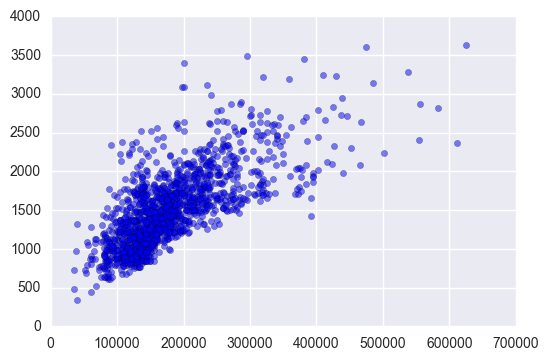

In [39]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from __future__ import division
import sklearn.linear_model as linear_model
pd.options.display.max_rows = 2000

#Loading the training and the test data
Train_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/train.csv')


#print (Train_df.columns)
#print (Train_df.describe())

# No of columns in the df
#print (Train_df.info())

#Segregating Quantitative and Qualitative columns
quantitative = [f for f in Train_df.columns if Train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in Train_df.columns if Train_df.dtypes[f] == 'object']

# checking the columns with NaN values
NaN_columns = {}
for i in Train_df.columns:
    if pd.isnull(Train_df[i]).sum() >0:
        NaN_columns[i] = pd.isnull(Train_df[i]).sum()
print (NaN_columns)

# plotting Sale Price versus GR Living Area
Train_df = Train_df[Train_df.GrLivArea < 4000]
plt.scatter(Train_df.SalePrice,Train_df.GrLivArea,alpha = 0.5)
print (len(Train_df))


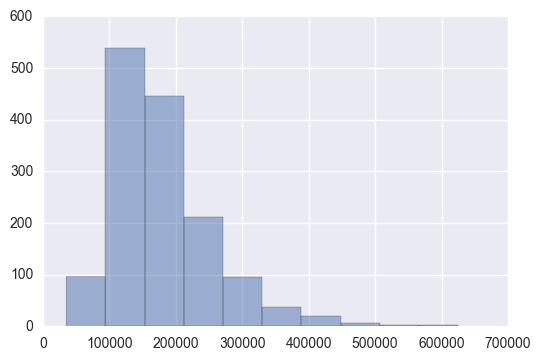

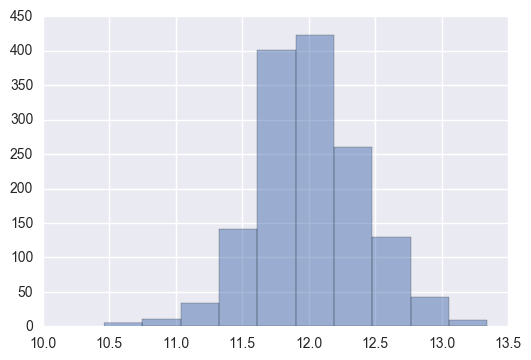

In [40]:
#Analysing the sale price normality and applying log transformation since the original values are right skewed
plt.hist(Train_df['SalePrice'], alpha = 0.5)
plt.show()
y =np.log(Train_df['SalePrice'])
plt.hist(y,alpha = 0.5)
plt.show()


In [41]:
# Treatment of Nan Values in Quantitative data
for i in quantitative:
    if i in NaN_columns:
        print (i)

#LotFrontage/MasVnrArea/GarageYrBlt
# If Na is there in LotFrontage then no area is present
Train_df['LotFrontage'] = Train_df['LotFrontage'].fillna(0)

# MasVnrArea is Nan means there is no veneer area in the house
Train_df['MasVnrArea'] = Train_df['MasVnrArea'].fillna(0)

# If GarageYrBlt has Nan most likely no garage in the house but again it is a discrete variable
Train_df['GarageYrBlt']=Train_df['GarageYrBlt'].fillna(0)

# Checking the Quanlitative variable and adding a category MISSING if Nan is present
for i in qualitative:
    if i in NaN_columns:
        print (i)

        # For all the above except Electrical -
#NA means the feature is not available in the house and hence can be safely substituted as 0
qualitative.remove('Electrical')
for i in qualitative:
    if Train_df[i].isnull().any():
        Train_df[i]=Train_df[i].fillna("MISSING")
qualitative.append('Electrical')     
Train_df['Electrical'] = Train_df['Electrical'].fillna('FuseA') # filling the average value

LotFrontage
MasVnrArea
GarageYrBlt
Alley
MasVnrType
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [42]:
#some numerical features which are actually categories

Train_df = Train_df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
# Working on ordinal variables and simplifying them

# check for YrSold

def YearSold(df):
    df.loc[df['YrSold'] < df['YearRemodAdd'], 'YrSold'] = df['YearRemodAdd']
    return df

Train_df = YearSold(Train_df)

def Simplification(df):
    df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    #Encoding ordinal features into numbers
    df = df.replace({"Alley" : {"MISSING":0,"Grvl" : 1, "Pave" : 2},
                           "BsmtCond" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "BsmtExposure" : {"MISSING" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"MISSING" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"MISSING" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtQual" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                           "ExterCond" : {"MISSING":0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "ExterQual" : {"MISSING":0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "FireplaceQu" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "Functional" : {"MISSING":0,"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                           "Min2" : 6, "Min1" : 7, "Typ" : 8},
                           "GarageCond" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageQual" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "HeatingQC" : {"MISSING": 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "KitchenQual" : {"MISSING":0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"MISSING" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "Street" : {"Grvl" : 1, "Pave" : 2},
                           "Utilities" : {"MISSING" :0,"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                         )
    return df
Train_df = Simplification(Train_df)

def Combinations(df):
    #Lot score
    df['LotScore']= ([i*2 for i in df['LotFrontage']] +df['LotArea'])*df['LotShape']

    #Overall score for the house 
    df['OverallScore']=df['OverallCond']*df['OverallQual']

    #Garage Score
    df["GarageScore"] = df["GarageQual"] * df["GarageCond"]

    #External score
    df["ExterScore"] = df["ExterQual"] * df["ExterCond"]

    #Basement Score
    df["BaseScore"] = df["BsmtQual"] * df["BsmtCond"]

    #PoolScore
    df["PoolScore"] = df["PoolArea"] * df["PoolQC"]

    #KitchenScore 
    df["KitchenScore"] = df["KitchenAbvGr"]  *df["KitchenQual"]

    #Fireplace Score
    df["FireScore"] = df["Fireplaces"] * df["FireplaceQu"]

    #Total Porch and Deck
    df["PorchDeck"] = df["OpenPorchSF"] + df["EnclosedPorch"] +\
    df["3SsnPorch"] + df["ScreenPorch"]+df['WoodDeckSF']

    # Total number of bathrooms
    df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
    df["FullBath"] + (0.5 * df["HalfBath"])

    #Total SquareFoot
    df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]+df["1stFlrSF"] + df["2ndFlrSF"]

    # Has masonry veneer or not
    df["HasMasVnr"] = df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})

    df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})

    #House Age at the time of sale

    df['HouseAge'] =  df['YrSold']-df['YearBuilt'] 
    df['RemodelAge'] = df['YrSold']-df['YearRemodAdd']
    df['HouseScore'] = df['HouseAge'] * (df['RemodelAge']*0.5)
    return df
Train_df = Combinations(Train_df)

In [43]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = Train_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000000
AllSF               0.811232
OverallQual         0.800858
GrLivArea           0.720516
ExterQual           0.694628
SimplOverallQual    0.676212
KitchenQual         0.666217
GarageCars          0.649256
TotalBsmtSF         0.646584
GarageArea          0.636964
TotalBath           0.635939
1stFlrSF            0.625235
BsmtQual            0.592073
ExterScore          0.586221
BaseScore           0.579380
OverallScore        0.566514
FullBath            0.559048
TotRmsAbvGrd        0.537462
YearBuilt           0.535279
FireplaceQu         0.528841
YearRemodAdd        0.521428
FireScore           0.509796
MasVnrArea          0.473650
Fireplaces          0.466765
HeatingQC           0.435081
KitchenScore        0.407556
PorchDeck           0.397400
BsmtFinSF1          0.395923
BoughtOffPlan       0.371494
OpenPorchSF         0.330361
WoodDeckSF          0.322538
BsmtFinType1        0.305114
2ndFlrSF            0.29

In [44]:
#Creating Polynomials
def Polynomials(df):
    df['AllSF^2'] =df['AllSF']**2
    df['OverallQual^2'] = df['OverallQual']**2
    df['GrLivArea^2'] =df['GrLivArea']**2
    df['ExterQual^2'] =df['ExterQual']**2
    df['SimplOverallQual^2'] =df['SimplOverallQual']**2
    df['GarageCars^2'] =df['GarageCars']**2
    df['KitchenScore^2'] = df['KitchenScore']**2
    df['TotalBsmtSF^2'] =df['TotalBsmtSF']**2
    df['TotalBath^2'] =df['TotalBath']**2
    df['GarageArea^2'] =df['GarageArea']**2
    df['1stFlrSF^2'] =df['1stFlrSF']**2
    df['ExterScore^2'] =df['ExterScore']**2
    df['OverallScore^2'] =df['OverallScore']**2
    df['FullBath^2'] =df['FullBath']**2
    df['TotRmsAbvGrd^2'] =df['TotRmsAbvGrd']**2

    df['HouseScore^2'] =df['HouseScore']**2
    df['RemodelAge^2'] =df['RemodelAge']**2
    df['HouseAge^2'] =df['HouseAge']**2
    return df
Train_df =Polynomials(Train_df)

# re-splitting into numeric and categorical
quantitative = [f for f in Train_df.columns if Train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in Train_df.columns if Train_df.dtypes[f] == 'object']
print (len(quantitative))
print (len(qualitative))
train_num = Train_df[quantitative]
train_cat = Train_df[qualitative]
print (train_num.columns)
print (train_cat.columns)

88
27
Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'MiscVal', 'YrSold', 'SimplOverallQual', 'SimplOverallCond',
       'LotScore', 'OverallScore', 'GarageScore', 'ExterScore', 'BaseScore',
       'PoolScore', 'KitchenScore', 'FireScore', 'PorchDeck', 'TotalBath',
 

In [45]:
#adjusting skewness
from scipy.stats import skew
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

#creating dummy variable
train_cat = pd.get_dummies(train_cat) 

#Joining them all to get the training set
Train = pd.concat([train_num,train_cat],axis =1)



71 skewed numerical features to log transform


C:\Users\Mash\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


[ 0.78682561  0.77766109  0.7798808 ]


In [55]:
# Splitting into training and test sets
from sklearn import metrics

from sklearn.cross_validation import train_test_split,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(Train, y, test_size = 0.20, random_state = 0)

from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
clf =clf.fit(X_train,y_train)
score = cross_val_score(clf,Train,y)
print (score)
alpha =clf.alpha_

print("Try again for more precision with alphas centered around " + str(alpha))
clf = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
clf.fit(X_train, y_train)
print (clf.alpha_)

y_train_predict = np.exp(clf.predict(X_train))
y_test_predict = np.exp(clf.predict(X_test))

[ 0.92055233  0.90767859  0.91836214]
Try again for more precision with alphas centered around 10.0
9.5


In [56]:
#Preparing the Test DF
import csv
Test_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/test.csv')
tquantitative = [f for f in Test_df.columns if Test_df.dtypes[f] != 'object']
tquantitative.remove('Id')
tqualitative = [f for f in Test_df.columns if Test_df.dtypes[f] == 'object']
NaN_columns = {}

for i in Test_df.columns:
    if pd.isnull(Test_df[i]).sum() >0:
        NaN_columns[i] = pd.isnull(Test_df[i]).sum()
print (NaN_columns)


for i in tquantitative:
    Test_df[i] = Test_df[i].fillna(0)

for i in tqualitative:
    Test_df[i] = Test_df[i].fillna('MISSING')
    
Test_df = Test_df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
Test_df = YearSold(Test_df)
Test_df = Simplification(Test_df)
Test_df=Combinations(Test_df)
Test_df=Polynomials(Test_df)


{'GarageYrBlt': 78, 'BsmtCond': 45, 'GarageCond': 78, 'TotalBsmtSF': 1, 'BsmtUnfSF': 1, 'Fence': 1169, 'KitchenQual': 1, 'LotFrontage': 227, 'MasVnrArea': 15, 'BsmtFinType2': 42, 'BsmtFinType1': 42, 'Utilities': 2, 'MiscFeature': 1408, 'Alley': 1352, 'BsmtQual': 44, 'GarageCars': 1, 'BsmtFinSF2': 1, 'MSZoning': 4, 'GarageFinish': 78, 'Exterior1st': 1, 'BsmtHalfBath': 2, 'GarageType': 76, 'GarageQual': 78, 'PoolQC': 1456, 'Exterior2nd': 1, 'BsmtFinSF1': 1, 'MasVnrType': 16, 'BsmtFullBath': 2, 'SaleType': 1, 'FireplaceQu': 730, 'BsmtExposure': 44, 'GarageArea': 1, 'Functional': 2}


In [57]:
#Handling further null values
print(Test_df.shape)

tquantitative = [f for f in Test_df.columns if Test_df.dtypes[f] != 'object']
tquantitative.remove('Id')
print (len(tquantitative))
tqualitative = [f for f in Test_df.columns if Test_df.dtypes[f] == 'object']
print (len(tqualitative))
test_num = Test_df[tquantitative]
test_cat = Test_df[tqualitative]
# Updating nulls with median values for remaining numerical variables

test_num = test_num.fillna(test_num.median())
test_num[skewed_features] = np.log1p(test_num[skewed_features])
# Creating dummy variable
test_cat = pd.get_dummies(test_cat) 



    

(1459, 116)
88
27


In [58]:
#Joining them all to get the Test set
Test = pd.concat([test_num,test_cat],axis =1)
# adding columsn which are in train but not in test
missing_cols = set( Train.columns ) - set( Test.columns )
for c in missing_cols:
    Test[c] = 0
print (Test.shape)

# deleting columns which are in test but not in train
extra_cols = set(Test.columns) - set(Train.columns)
if extra_cols:
    print ("extra columns:", extra_cols)
Test = Test[Train.columns]
    
print (set(Train.columns) - set(Test.columns))
'''#print (np.any(np.isnan(Test)))
#print (np.isfinite(Test).all())
print (Test.iloc[1089])
X= np.asanyarray(Test)
if (np.isfinite(X).all()):
        print  ("Input contains NaN, infinity or a value too large for %r." % X.dtype)'''
y_predict = np.exp(clf.predict(Test))


#Writing the output
predictions_file = open("C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/EDA_output.csv", "w",newline='')
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["Id", "SalePrice"])
for i in range(len(Test_df)):
    predictions_file_object.writerow([Test_df['Id'][i],y_predict[i]])
predictions_file.close()


(1459, 301)
extra columns: {'MSSubClass_SC150', 'SaleType_MISSING', 'MSZoning_MISSING', 'Exterior1st_MISSING', 'Exterior2nd_MISSING'}
set()
